In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import math
%matplotlib inline

# 514 Programming Assignment 2
#### Group: Rashaan, Ravi, David

Data additional information
Each record is an example of a hand consisting of five playing cards drawn from a standard deck of 52. 
Each card is described using two attributes (suit and rank), for a total of 10 predictive attributes. 
There is one Class attribute that describes the "Poker Hand". 
The order of cards is important, which is why there are 480 possible Royal Flush hands as compared to 4

#### Load dataset

In [3]:
# Column names for the dataset
# Define the column names for your dataset
columns = ['S1', 'C1', 'S2', 'C2', 'S3', 'C3', 'S4', 'C4', 'S5', 'C5', 'Class']

# Load your dataset
training_data = pd.read_csv('poker-hand-training-true.csv', header=None, names=columns)
testing_data = pd.read_csv('poker-hand-testing.csv', header=None, names=columns)

# Adjust the ranks of cards, specifically changing Ace from 1 to 14
def adjust_ranks(data):
    for i in range(1, 6):  # For each card in the hand
        data[f'C{i}'] = data[f'C{i}'].apply(lambda x: 14 if x == 1 else x)
    return data

# One-hot encode the suits of the cards
def one_hot_encode_suits(data):
    for i in range(1, 6):  # For each card in the hand
        data = pd.concat([data, pd.get_dummies(data[f'S{i}'], prefix=f'S{i}')], axis=1).drop([f'S{i}'], axis=1)
    return data

# Apply preprocessing steps
def preprocess_data(data):
    data = adjust_ranks(data)
    data = one_hot_encode_suits(data)
    return data

training_data_preprocessed = preprocess_data(training_data)
testing_data_preprocessed = preprocess_data(testing_data)


# PCA - Part D

In [4]:
from sklearn.naive_bayes import CategoricalNB,BernoulliNB,MultinomialNB,GaussianNB,ComplementNB
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import KFold,StratifiedKFold,cross_val_score
from sklearn.metrics import mean_absolute_error,mean_squared_error,classification_report,confusion_matrix

##### PREPARE THE TRAINING AND TESTING SETS

In [5]:
def adjust_class(data):
        bad,good,great = 0,4,9
        #BAD
        data['Class'] = data['Class'].apply(lambda x: bad if x == 0 else x)
        data['Class'] = data['Class'].apply(lambda x: bad if x == 1 else x)
        data['Class'] = data['Class'].apply(lambda x: bad if x == 2 else x)
        data['Class'] = data['Class'].apply(lambda x: bad if x == 3 else x)
        #GOOD
        data['Class'] = data['Class'].apply(lambda x: good if x == 4 else x)
        data['Class'] = data['Class'].apply(lambda x: good if x == 5 else x)
        data['Class'] = data['Class'].apply(lambda x: good if x == 6 else x)
        #GREAT
        data['Class'] = data['Class'].apply(lambda x: great if x == 7 else x)
        data['Class'] = data['Class'].apply(lambda x: great if x == 8 else x)
        data['Class'] = data['Class'].apply(lambda x: great if x == 9 else x)
        return data

def remove_val_df(df,v):
    temp_df = copy.deepcopy(adjust_class(df))   
    indexClass = temp_df[(temp_df['Class']==v)].index
    temp_df.drop(indexClass,inplace=True)
    return temp_df

In [6]:
df_rm_0 = remove_val_df(training_data_preprocessed,0)
df_rm_4 = remove_val_df(training_data_preprocessed,4)
df_rm_9 = remove_val_df(training_data_preprocessed,9)

# Dimension Reduction

In [7]:
df_rm_0.head()

,C1,C2,C3,C4,C5,Class,S1_1,S1_2,S1_3,S1_4,...,S3_3,S3_4,S4_1,S4_2,S4_3,S4_4,S5_1,S5_2,S5_3,S5_4
0,10,11,13,12,14,9,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
1,11,13,10,12,14,9,False,True,False,False,...,False,False,False,True,False,False,False,True,False,False
2,12,11,13,10,14,9,False,False,True,False,...,True,False,False,False,True,False,False,False,True,False
3,10,11,14,13,12,9,False,False,False,True,...,False,True,False,False,False,True,False,False,False,True
4,14,13,12,11,10,9,False,False,False,True,...,False,True,False,False,False,True,False,False,False,True


In [8]:
df_rm_4.head()

,C1,C2,C3,C4,C5,Class,S1_1,S1_2,S1_3,S1_4,...,S3_3,S3_4,S4_1,S4_2,S4_3,S4_4,S5_1,S5_2,S5_3,S5_4
0,10,11,13,12,14,9,True,False,False,False,...,False,False,True,False,False,False,True,False,False,False
1,11,13,10,12,14,9,False,True,False,False,...,False,False,False,True,False,False,False,True,False,False
2,12,11,13,10,14,9,False,False,True,False,...,True,False,False,False,True,False,False,False,True,False
3,10,11,14,13,12,9,False,False,False,True,...,False,True,False,False,False,True,False,False,False,True
4,14,13,12,11,10,9,False,False,False,True,...,False,True,False,False,False,True,False,False,False,True


In [9]:
df_rm_9.head()

,C1,C2,C3,C4,C5,Class,S1_1,S1_2,S1_3,S1_4,...,S3_3,S3_4,S4_1,S4_2,S4_3,S4_4,S5_1,S5_2,S5_3,S5_4
10,14,14,9,5,3,0,True,False,False,False,...,True,False,True,False,False,False,False,True,False,False
11,6,14,13,4,9,0,False,True,False,False,...,False,True,False,True,False,False,False,False,False,True
12,10,6,2,14,8,0,True,False,False,False,...,False,False,True,False,False,False,False,False,True,False
13,13,14,4,5,11,0,False,True,False,False,...,False,True,True,False,False,False,False,True,False,False
14,8,12,9,2,2,0,False,False,True,False,...,True,False,False,False,False,True,False,False,True,False


In [10]:
from sklearn.preprocessing import StandardScaler #adjust so each fearure has a single unit variance scaler

In [11]:
# CLASS 1: ONLY GOOD AND GREAT ###########
x_train_0 = df_rm_0[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_train_0 = pd.DataFrame(df_rm_0['Class'])

x_test_0 = df_rm_0[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_test_0 = pd.DataFrame(df_rm_0['Class'])

# CLASS 2: ONLY BAD AND GREAT ###########
x_train_4 = df_rm_4[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_train_4 = pd.DataFrame(df_rm_4['Class'])

x_test_4 = df_rm_4[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_test_4 = pd.DataFrame(df_rm_4['Class'])

# CLASS 3: ONLY BAD AND GOOD ###########
x_train_9 = df_rm_9[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_train_9 = pd.DataFrame(df_rm_9['Class'])

x_test_9 = df_rm_9[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_test_9 = pd.DataFrame(df_rm_9['Class'])

# CLASS EC: ALL ###########
x_train_all = training_data_preprocessed[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_train_all = pd.DataFrame(training_data_preprocessed['Class'])

x_test_all = training_data_preprocessed[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S3_1', 'S3_2', 'S3_3', 'S3_4', 'S4_1',
       'S4_2', 'S4_3', 'S4_4', 'S5_1', 'S5_2', 'S5_3', 'S5_4']]

y_test_all = pd.DataFrame(training_data_preprocessed['Class'])

In [12]:
scaler_df_rm_0 = StandardScaler().fit(x_train_0)
scaler_df_rm_4 = StandardScaler().fit(x_train_4)
scaler_df_rm_9 = StandardScaler().fit(x_train_9)

In [13]:
scaler_data_df_rm_0 = scaler_df_rm_0.transform(x_train_0)
scaler_data_df_rm_4 = scaler_df_rm_4.transform(x_train_4)
scaler_data_df_rm_9 = scaler_df_rm_9.transform(x_train_9)

## PCA Process

In [14]:
from sklearn.decomposition import PCA

In [15]:
pca_df_rm_0 = PCA(n_components = 25).fit(scaler_data_df_rm_0)
pca_df_rm_4 = PCA(n_components = 25).fit(scaler_data_df_rm_4)
pca_df_rm_9 = PCA(n_components = 25).fit(scaler_data_df_rm_9)

In [16]:
pca_data_df_rm_0 = pca_df_rm_0.transform(scaler_data_df_rm_0)
pca_data_df_rm_4 = pca_df_rm_4.transform(scaler_data_df_rm_4)
pca_data_df_rm_9 = pca_df_rm_9.transform(scaler_data_df_rm_9)

In [17]:
def percentage_of_variance(data):
    sum_data = sum(data)
    res = []
    for i in range(len(data)):
        res.append((data[i]/sum_data)*100.0)
    isHalfDataVarianceTotal = 0.0
    half_len_res = math.floor(len(res)/2)
    for i in range(half_len_res):
        isHalfDataVarianceTotal += res[i]
    res = (pd.DataFrame(res))
    return res,isHalfDataVarianceTotal

In [18]:
percentage_of_explained_variance_df_0, isHalf_0 = percentage_of_variance(pca_df_rm_0.explained_variance_)
percentage_of_explained_variance_df_4, isHalf_4 = percentage_of_variance(pca_df_rm_4.explained_variance_)
percentage_of_explained_variance_df_9, isHalf_9 = percentage_of_variance(pca_df_rm_9.explained_variance_)

In [19]:
print(isHalf_0)
print(isHalf_4)
print(isHalf_9)

79.61624828684737
65.52939474181544
65.42563090216493


In [20]:
def PCA_visualize_percentage(data,title="PCA"):
    import matplotlib.ticker as mtick
    fig = plt.figure(figsize=(11,6))
    ax = fig.add_subplot(1,1,1)
    plt.plot(data)
    len_data = len(data)
    for i in range(len_data):
        plt.plot(i,data.iloc[i],marker='s')
    plt.xticks(np.arange(0,len_data))
    plt.title(title)
    plt.xlabel("Component Number")
    plt.ylabel("Percentage Variance")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.show()

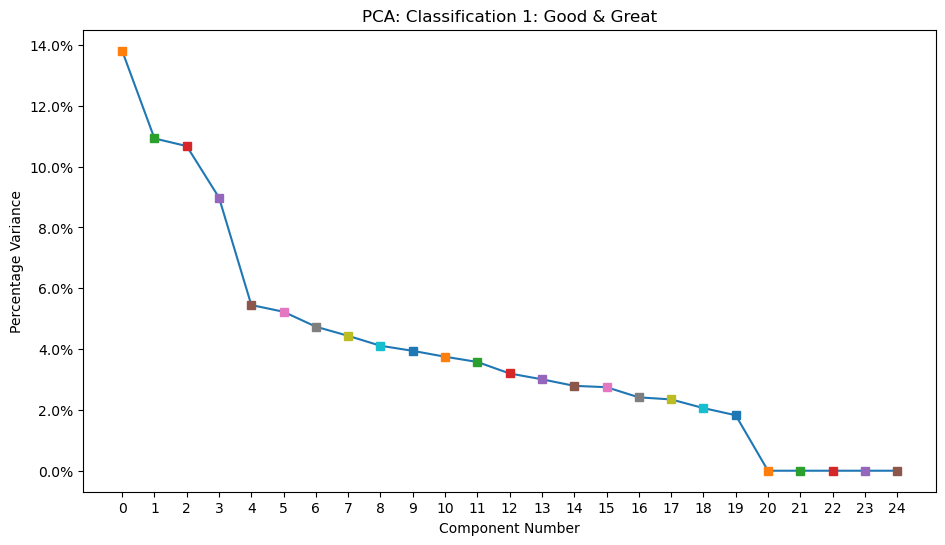

In [21]:
PCA_visualize_percentage(percentage_of_explained_variance_df_0,"PCA: Classification 1: Good & Great") 

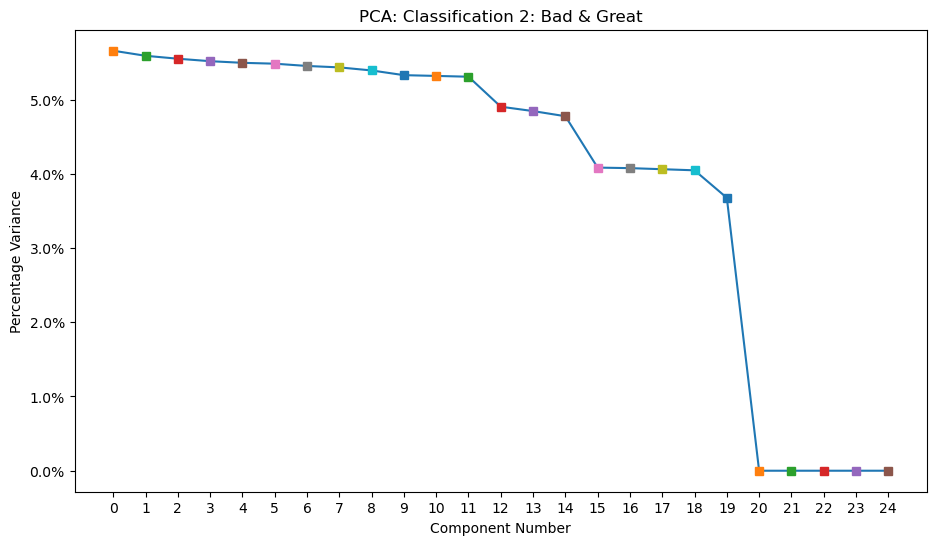

In [22]:
PCA_visualize_percentage(percentage_of_explained_variance_df_4,"PCA: Classification 2: Bad & Great") 

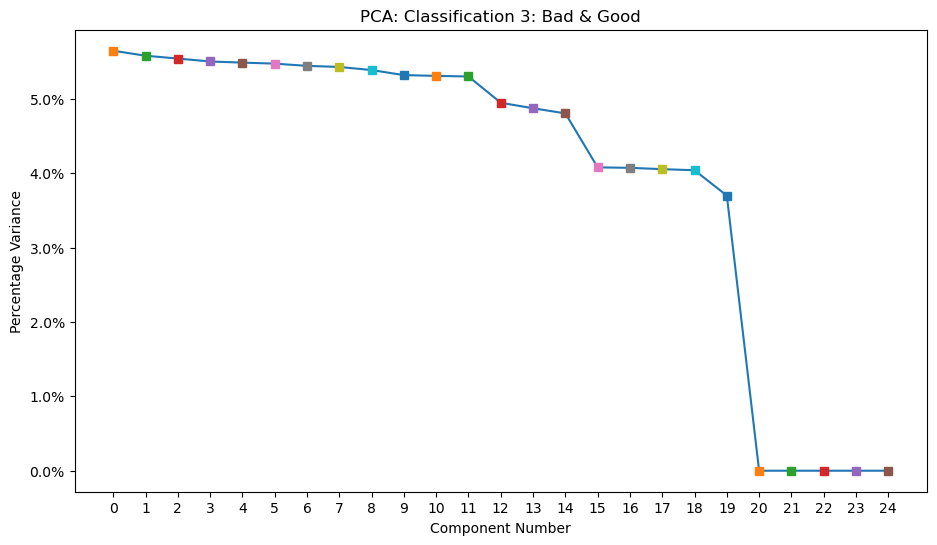

In [23]:
PCA_visualize_percentage(percentage_of_explained_variance_df_9,"PCA: Classification 3: Bad & Good") 

# Heatmap: class 1

<Axes: >

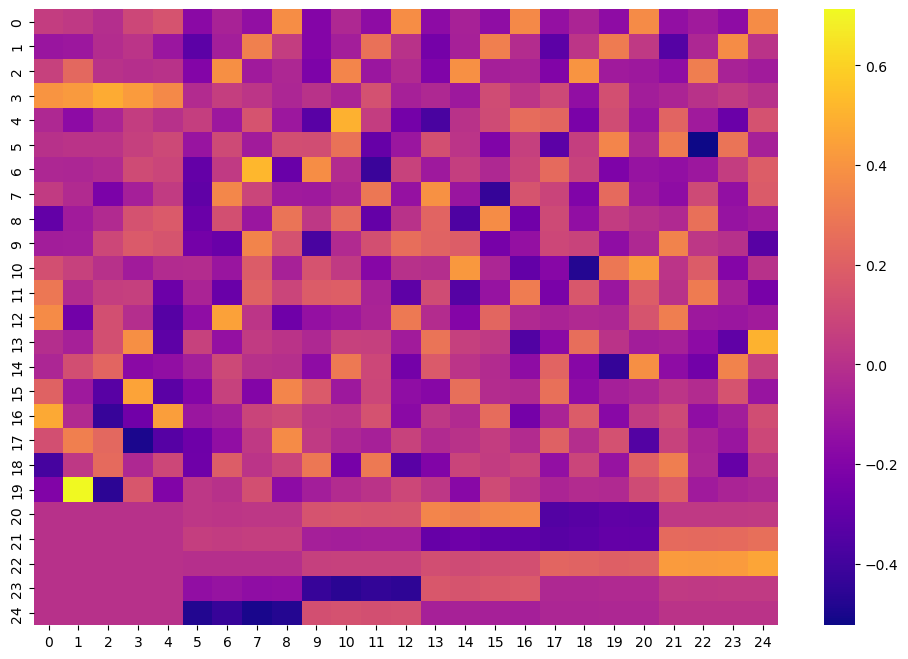

In [24]:
plt.figure(figsize=(12,8))
sns.heatmap(pca_df_rm_0.components_,cmap='plasma')

# Heatmap: class 2

<Axes: >

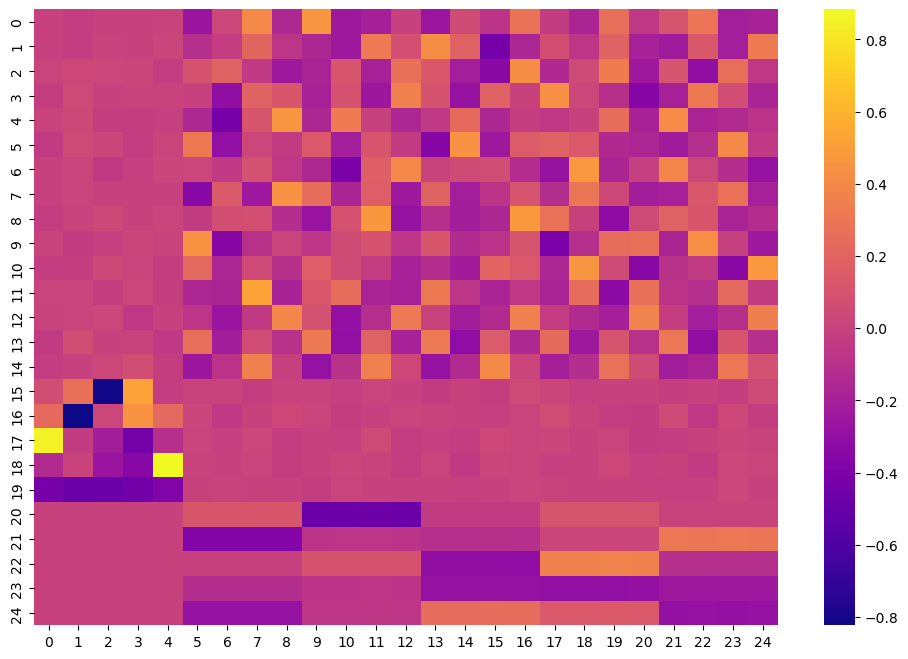

In [25]:
plt.figure(figsize=(12,8))
sns.heatmap(pca_df_rm_4.components_,cmap='plasma')

# Heatmap: class 3

<Axes: >

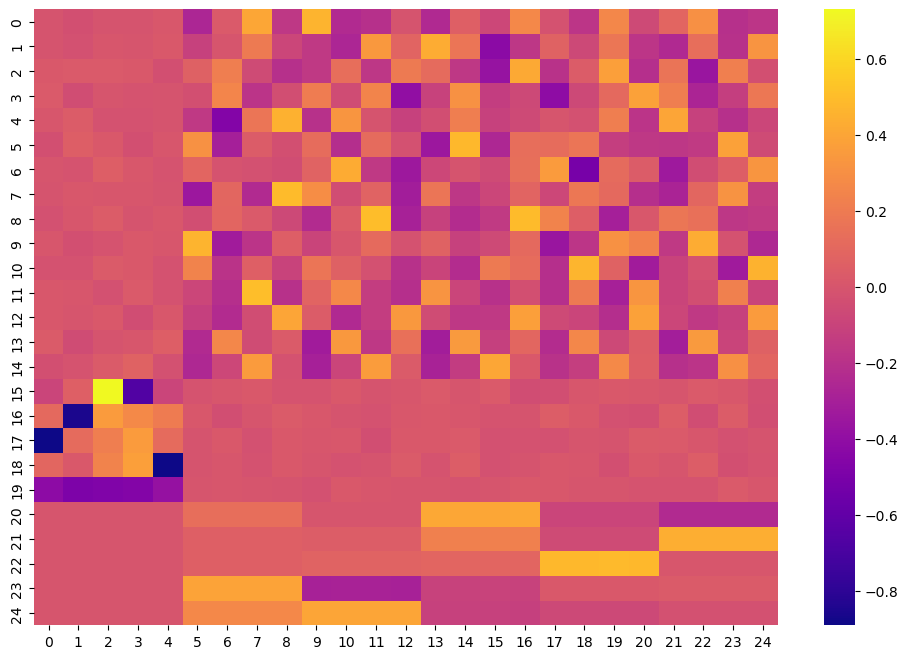

In [26]:
plt.figure(figsize=(12,8))
sns.heatmap(pca_df_rm_9.components_,cmap='plasma')

In [27]:
# CLASS 1: ONLY GOOD AND GREAT ###########
x_train_0 = df_rm_0[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3']]

y_train_0 = pd.DataFrame(df_rm_0['Class'])

x_test_0 = df_rm_0[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3']]

y_test_0 = pd.DataFrame(df_rm_0['Class'])

# CLASS 2: ONLY BAD AND GREAT ###########
x_train_4 = df_rm_4[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3']]

y_train_4 = pd.DataFrame(df_rm_4['Class'])

x_test_4 = df_rm_4[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3']]

y_test_4 = pd.DataFrame(df_rm_4['Class'])

# CLASS 3: ONLY BAD AND GOOD ###########
x_train_9 = df_rm_9[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3']]

y_train_9 = pd.DataFrame(df_rm_9['Class'])

x_test_9 = df_rm_9[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3']]

y_test_9 = pd.DataFrame(df_rm_9['Class'])

# CLASS EC: ALL ###########
x_train_all = training_data_preprocessed[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3']]

y_train_all = pd.DataFrame(training_data_preprocessed['Class'])

x_test_all = training_data_preprocessed[['C1', 'C2', 'C3', 'C4', 'C5', 'S1_1', 'S1_2', 'S1_3', 'S1_4',
       'S2_1', 'S2_2', 'S2_3']]

y_test_all = pd.DataFrame(training_data_preprocessed['Class'])

In [32]:
df_0_train_reduced = pd.DataFrame(x_train_0)
df_0_train_reduced['Class']=y_train_0
print(df_0_train_reduced.head())

df_0_test_reduced = pd.DataFrame(x_test_0)
df_0_test_reduced['Class']=y_test_0
print(df_0_test_reduced.head())

   C1  C2  C3  C4  C5   S1_1   S1_2   S1_3   S1_4   S2_1   S2_2   S2_3  Class
0  10  11  13  12  14   True  False  False  False   True  False  False      9
1  11  13  10  12  14  False   True  False  False  False   True  False      9
2  12  11  13  10  14  False  False   True  False  False  False   True      9
3  10  11  14  13  12  False  False  False   True  False  False  False      9
4  14  13  12  11  10  False  False  False   True  False  False  False      9
   C1  C2  C3  C4  C5   S1_1   S1_2   S1_3   S1_4   S2_1   S2_2   S2_3  Class
0  10  11  13  12  14   True  False  False  False   True  False  False      9
1  11  13  10  12  14  False   True  False  False  False   True  False      9
2  12  11  13  10  14  False  False   True  False  False  False   True      9
3  10  11  14  13  12  False  False  False   True  False  False  False      9
4  14  13  12  11  10  False  False  False   True  False  False  False      9


In [34]:
df_4_train_reduced = pd.DataFrame(x_train_4)
df_4_train_reduced['Class']=y_train_4
print(df_4_train_reduced.head())

df_4_test_reduced = pd.DataFrame(x_test_4)
df_4_test_reduced['Class']=y_test_4
print(df_4_test_reduced.head())

   C1  C2  C3  C4  C5   S1_1   S1_2   S1_3   S1_4   S2_1   S2_2   S2_3  Class
0  10  11  13  12  14   True  False  False  False   True  False  False      9
1  11  13  10  12  14  False   True  False  False  False   True  False      9
2  12  11  13  10  14  False  False   True  False  False  False   True      9
3  10  11  14  13  12  False  False  False   True  False  False  False      9
4  14  13  12  11  10  False  False  False   True  False  False  False      9
   C1  C2  C3  C4  C5   S1_1   S1_2   S1_3   S1_4   S2_1   S2_2   S2_3  Class
0  10  11  13  12  14   True  False  False  False   True  False  False      9
1  11  13  10  12  14  False   True  False  False  False   True  False      9
2  12  11  13  10  14  False  False   True  False  False  False   True      9
3  10  11  14  13  12  False  False  False   True  False  False  False      9
4  14  13  12  11  10  False  False  False   True  False  False  False      9


In [35]:
df_9_train_reduced = pd.DataFrame(x_train_9)
df_9_train_reduced['Class']=y_train_9
print(df_4_train_reduced.head())

df_9_test_reduced = pd.DataFrame(x_test_9)
df_9_test_reduced['Class']=y_test_9
print(df_9_test_reduced.head())

   C1  C2  C3  C4  C5   S1_1   S1_2   S1_3   S1_4   S2_1   S2_2   S2_3  Class
0  10  11  13  12  14   True  False  False  False   True  False  False      9
1  11  13  10  12  14  False   True  False  False  False   True  False      9
2  12  11  13  10  14  False  False   True  False  False  False   True      9
3  10  11  14  13  12  False  False  False   True  False  False  False      9
4  14  13  12  11  10  False  False  False   True  False  False  False      9
    C1  C2  C3  C4  C5   S1_1   S1_2   S1_3   S1_4   S2_1   S2_2   S2_3  Class
10  14  14   9   5   3   True  False  False  False  False   True  False      0
11   6  14  13   4   9  False   True  False  False  False   True  False      0
12  10   6   2  14   8   True  False  False  False  False  False  False      0
13  13  14   4   5  11  False   True  False  False  False   True  False      0
14   8  12   9   2   2  False  False   True  False  False  False  False      0


In [ ]:
#creates the csv files

In [39]:
df_0_train_reduced.to_csv('partD_dataframes_to_csv/df_class_1_train_reduced.csv', index=False)  
df_0_test_reduced.to_csv('partD_dataframes_to_csv/df_class_1_test_reduced.csv', index=False)  

In [40]:
df_4_train_reduced.to_csv('partD_dataframes_to_csv/df_class_2_train_reduced.csv', index=False)  
df_4_test_reduced.to_csv('partD_dataframes_to_csv/df_class_2_test_reduced.csv', index=False)  

In [41]:
df_9_train_reduced.to_csv('partD_dataframes_to_csv/df_class_3_train_reduced.csv', index=False)  
df_9_test_reduced.to_csv('partD_dataframes_to_csv/df_class_3_test_reduced.csv', index=False)  

##### Methods

Artificial Neural Network:
Performed PCA on the data set and found that the first 12 features of the data set for binary class 1 accounts for 79.61624828684737 of the variance; binary class 2 accounts for 65.52939474181544 of the variance; binary class 3 accounts for 65.42563090216493 of the variance.